## Proyecto Security Data Science

### Fase 2: Modelo base, Métricas personalizadas y Función optimización.

### Miembros
* Fernanda Esquivel - 21542

### Link al repositorio
El repositorio puede ser visualizado [acá](https://github.com/FerEsq/SDS-Project)

## Implementación del modelo base

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
#Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style('whitegrid')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)

In [6]:
#Cargar los datasets
train_data = pd.read_csv('dataset/credit_card_fraud_features_train_madrugada.csv')
test_data = pd.read_csv('dataset/credit_card_fraud_features_test_madrugada.csv')
is_night_data = True

In [7]:
print(f"Dimensiones del conjunto de entrenamiento: {train_data.shape}")
print(f"Dimensiones del conjunto de prueba: {test_data.shape}")

Dimensiones del conjunto de entrenamiento: (629424, 75)
Dimensiones del conjunto de prueba: (112442, 75)


In [8]:
#Comprobar balance de clases
print("\nBalance de clases en el conjunto de entrenamiento:")
train_fraud_count = train_data['is_fraud'].value_counts()
train_fraud_pct = train_data['is_fraud'].value_counts(normalize=True) * 100
for i, (count, pct) in enumerate(zip(train_fraud_count, train_fraud_pct)):
    print(f"{'Fraude' if i == 1 else 'No fraude'}: {count} ({pct:.4f}%)")


Balance de clases en el conjunto de entrenamiento:
No fraude: 621687 (98.7708%)
Fraude: 7737 (1.2292%)


In [9]:
print("\nBalance de clases en el conjunto de prueba:")
test_fraud_count = test_data['is_fraud'].value_counts()
test_fraud_pct = test_data['is_fraud'].value_counts(normalize=True) * 100
for i, (count, pct) in enumerate(zip(test_fraud_count, test_fraud_pct)):
    print(f"{'Fraude' if i == 1 else 'No fraude'}: {count} ({pct:.4f}%)")


Balance de clases en el conjunto de prueba:
No fraude: 111670 (99.3134%)
Fraude: 772 (0.6866%)


### Preparación del dataset para el entrenamiento

In [10]:
#Columnas que definitivamente no sirven como features
exclude_cols = [
    'cc_num', 'first', 'last', 'trans_num', 'street', 'city', 'state', 'job', 
    'dob', 'merchant', 'date', 'month_year', 'datetime', 'first_tx_date', 'birth_date'
]

In [11]:
#Quitar columnas que no sirven como features
train_features = train_data.drop(columns=[col for col in exclude_cols if col in train_data.columns])
test_features = test_data.drop(columns=[col for col in exclude_cols if col in test_data.columns])

In [12]:
#Identificar columnas categóricas (object o category) y columns que son tipo bool
cat_cols = [col for col in train_features.columns if 
            train_features[col].dtype == 'object' or 
            train_features[col].dtype == 'category' or
            train_features[col].dtype == 'bool']

In [13]:
#Convertir columnas booleanas a enteros (0/1)
for col in train_features.columns:
    if train_features[col].dtype == 'bool':
        train_features[col] = train_features[col].astype(int)
        test_features[col] = test_features[col].astype(int)

In [14]:
#Verificar la lista de columnas categóricas
print(f"Columnas categóricas identificadas: {cat_cols}")

Columnas categóricas identificadas: ['category', 'gender', 'first_time_at_merchant', 'day_part', 'age_segment', 'category_simplified']


In [15]:
#Preparar las variables predictoras (X) y la variable objetivo (y)
y_train = train_features['is_fraud']
X_train = train_features.drop('is_fraud', axis=1)

y_test = test_features['is_fraud']
X_test = test_features.drop('is_fraud', axis=1)

In [16]:
#One-hot encoding para las variables categóricas
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

In [17]:
#Asegurarse de que train y test tienen las mismas columnas
train_cols = X_train.columns
test_cols = X_test.columns

In [18]:
#Añadir columnas faltantes en test
missing_cols = set(train_cols) - set(test_cols)
for col in missing_cols:
    X_test[col] = 0

In [19]:
#Usar solo columnas de entrenamiento y en el mismo orden
X_test = X_test[train_cols]

In [20]:
print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")

Dimensiones de X_train: (629424, 77)
Dimensiones de X_test: (112442, 77)


In [21]:
#Separar una porción del conjunto de entrenamiento para validación
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [22]:
#Crear el conjunto de datos para LightGBM
train_data_lgb = lgb.Dataset(X_train_split, label=y_train_split, categorical_feature='auto')
val_data_lgb = lgb.Dataset(X_val, label=y_val, reference=train_data_lgb, categorical_feature='auto')

In [30]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),  # Para manejar el desbalance
    # 'is_unbalance': True,  # Eliminado este parámetro para evitar el conflicto
    'max_depth': -1,  # No limitar la profundidad
}

### Entrenamiento del modelo

In [24]:
print(f"Ratio de clases (no fraude/fraude): {params['scale_pos_weight']:.2f}")
print(f"Parámetros del modelo:\n{params}")

Ratio de clases (no fraude/fraude): 80.35
Parámetros del modelo:
{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 31, 'learning_rate': 0.05, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'verbose': -1, 'scale_pos_weight': 80.35246219464909, 'is_unbalance': True, 'max_depth': -1}


In [31]:
model = lgb.train(
    params,
    train_data_lgb,
    num_boost_round=1000,
    valid_sets=[train_data_lgb, val_data_lgb],
    callbacks=[
        lgb.callback.early_stopping(stopping_rounds=50, verbose=True),
        lgb.callback.log_evaluation(period=50)
    ]
)

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.998585	valid_1's auc: 0.996757
[100]	training's auc: 0.999593	valid_1's auc: 0.998131
[150]	training's auc: 0.999812	valid_1's auc: 0.99871
[200]	training's auc: 0.9999	valid_1's auc: 0.998942
[250]	training's auc: 0.999941	valid_1's auc: 0.999054
[300]	training's auc: 0.999967	valid_1's auc: 0.999163
[350]	training's auc: 0.999983	valid_1's auc: 0.999167
Early stopping, best iteration is:
[308]	training's auc: 0.999971	valid_1's auc: 0.999198


In [32]:
#Guardar el modelo
model.save_model('models/fraud_detection_lgb_model.txt')
print("Modelo guardado como 'models/fraud_detection_lgb_model.txt'")

Modelo guardado como 'models/fraud_detection_lgb_model.txt'


In [34]:
#Predicciones
y_pred_val_proba = model.predict(X_val, num_iteration=model.best_iteration)
y_pred_test_proba = model.predict(X_test, num_iteration=model.best_iteration)

### Métricas

In [35]:
print("\nMétricas de evaluación en el conjunto de validación:")
val_auc = roc_auc_score(y_val, y_pred_val_proba)
print(f"AUC-ROC: {val_auc:.4f}")


Métricas de evaluación en el conjunto de validación:
AUC-ROC: 0.9992


In [36]:
thresholds = np.arange(0.01, 1.0, 0.01)
f1_scores = []

In [37]:
for threshold in thresholds:
    y_pred_val = (y_pred_val_proba >= threshold).astype(int)
    f1 = f1_score(y_val, y_pred_val)
    f1_scores.append(f1)

In [38]:
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

In [39]:
print(f"Mejor threshold basado en F1-score: {best_threshold:.4f}")
print(f"Mejor F1-score en validación: {best_f1:.4f}")

Mejor threshold basado en F1-score: 0.9300
Mejor F1-score en validación: 0.9384


In [40]:
#Aplicar el mejor threshold a las predicciones
y_pred_val = (y_pred_val_proba >= best_threshold).astype(int)
y_pred_test = (y_pred_test_proba >= best_threshold).astype(int)

In [48]:
#Métricas adicionales en validación
val_confusion = confusion_matrix(y_val, y_pred_val)
val_tn, val_fp, val_fn, val_tp = val_confusion.ravel()
val_precision = val_tp / (val_tp + val_fp) if (val_tp + val_fp) > 0 else 0
val_recall = val_tp / (val_tp + val_fn) if (val_tp + val_fn) > 0 else 0
val_specificity = val_tn / (val_tn + val_fp) if (val_tn + val_fp) > 0 else 0
val_f1 = f1_score(y_val, y_pred_val)

print("\nMétricas detalladas en validación:")
print(f"Precisión: {val_precision:.4f}")
print(f"Recall (Sensibilidad): {val_recall:.4f}")
print(f"Especificidad: {val_specificity:.4f}")
print(f"F1-Score: {val_f1:.4f}")


Métricas detalladas en validación:
Precisión: 0.9515
Recall (Sensibilidad): 0.9257
Especificidad: 0.9994
F1-Score: 0.9384


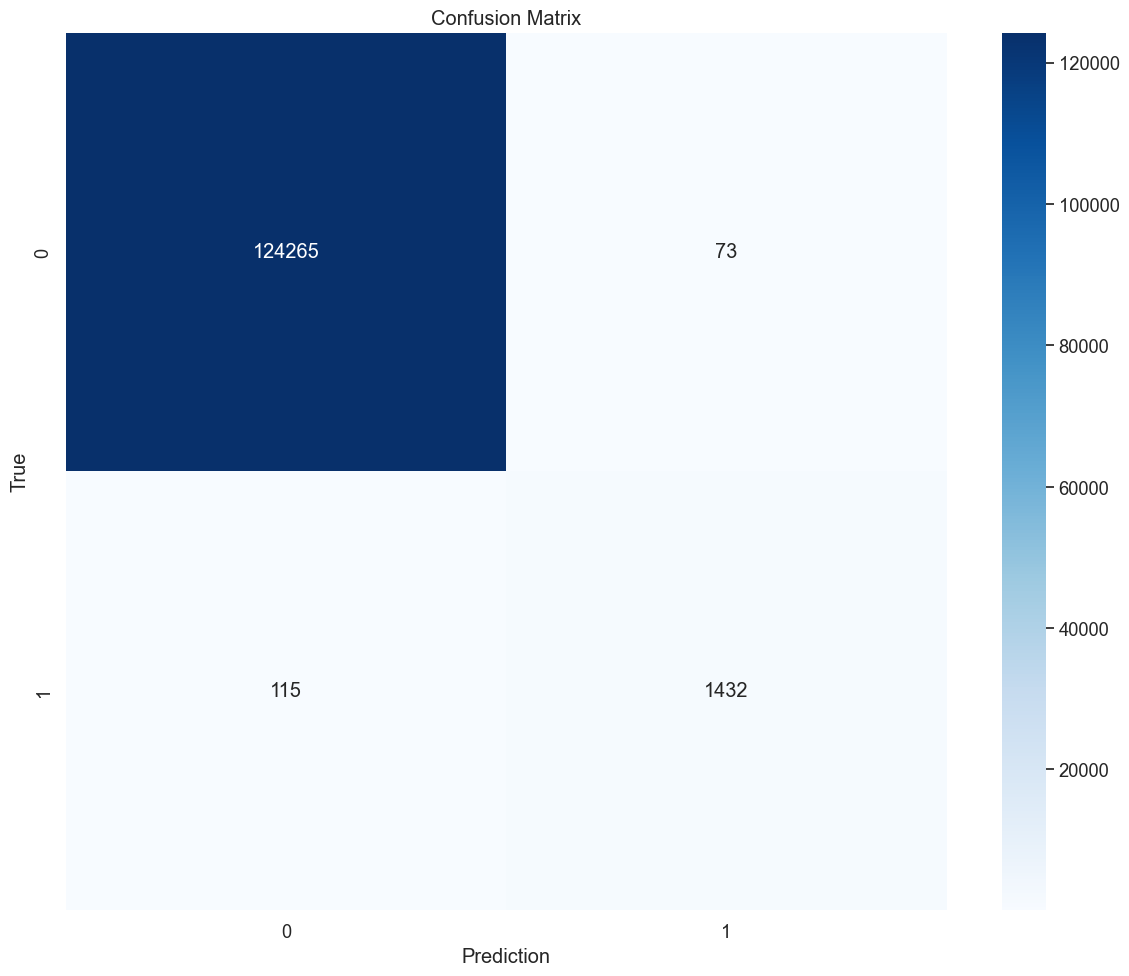

In [49]:
plt.figure(figsize=(12, 10))
sns.heatmap(val_confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [46]:
#Métricas en el conjunto de prueba
test_auc = roc_auc_score(y_test, y_pred_test_proba)
test_confusion = confusion_matrix(y_test, y_pred_test)
test_tn, test_fp, test_fn, test_tp = test_confusion.ravel()
test_precision = test_tp / (test_tp + test_fp) if (test_tp + test_fp) > 0 else 0
test_recall = test_tp / (test_tp + test_fn) if (test_tp + test_fn) > 0 else 0
test_specificity = test_tn / (test_tn + test_fp) if (test_tn + test_fp) > 0 else 0
test_f1 = f1_score(y_test, y_pred_test)

print("\nMétricas en el conjunto de prueba (diciembre):")
print(f"AUC-ROC: {test_auc:.4f}")
print(f"Precisión: {test_precision:.4f}")
print(f"Recall (Sensibilidad): {test_recall:.4f}")
print(f"Especificidad: {test_specificity:.4f}")
print(f"F1-Score: {test_f1:.4f}")


Métricas en el conjunto de prueba (diciembre):
AUC-ROC: 0.9984
Precisión: 0.9179
Recall (Sensibilidad): 0.8251
Especificidad: 0.9995
F1-Score: 0.8690


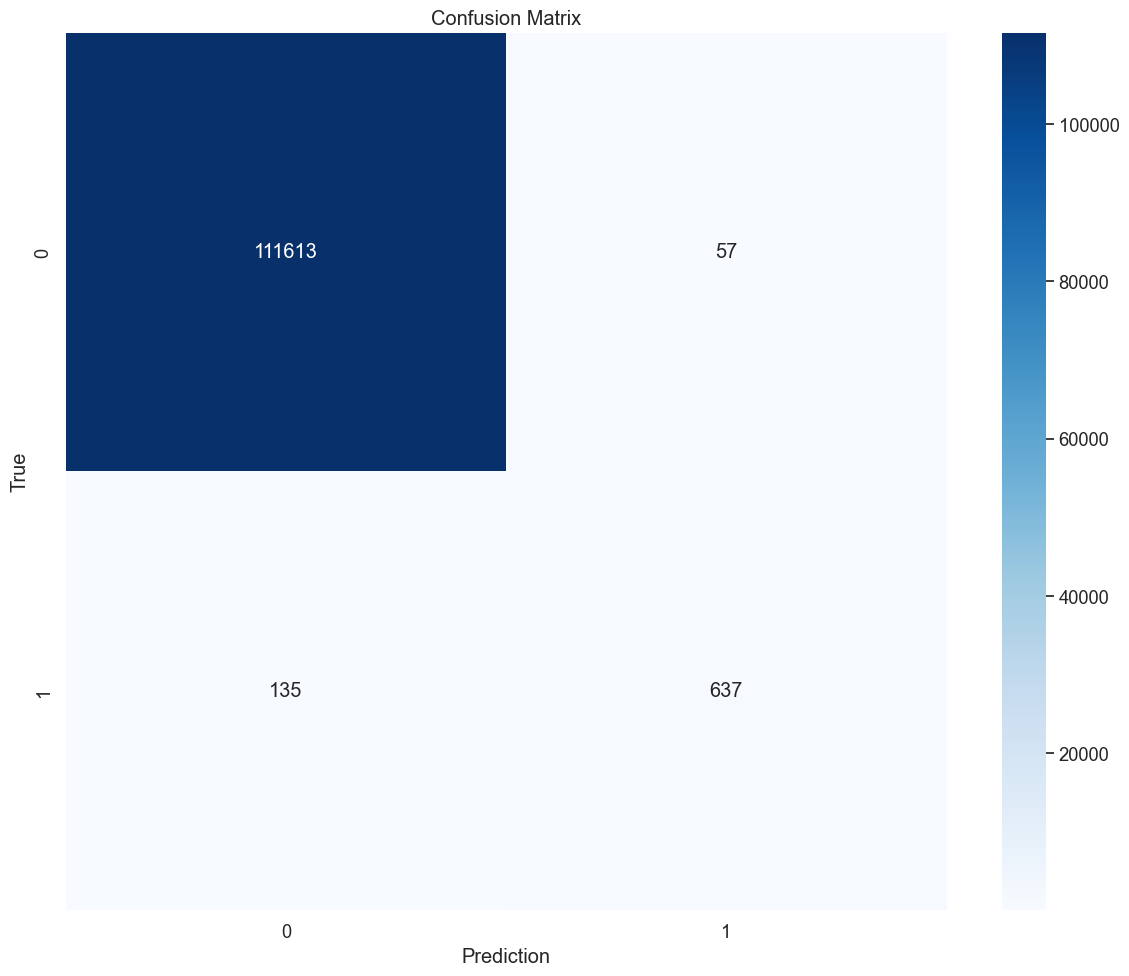

In [47]:
plt.figure(figsize=(12, 10))
sns.heatmap(test_confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.tight_layout()
plt.show()